# Matching Data

In this notebook, we demonstrate the MatchingData class, which organizes population data for matching, and some plotting tools for visualizing the data.

In [1]:
import logging 
logging.basicConfig(
    format="%(levelname)-4s [%(filename)s:%(lineno)d] %(message)s",
    level='INFO',
)

import pandas as pd

from pybalance import MatchingData, MatchingHeaders, split_target_pool, BetaBalance
from pybalance.genetic import GeneticMatcher
from pybalance.visualization import (
    plot_numeric_features, 
    plot_categoric_features, 
    plot_binary_features,
    plot_joint_numeric_distributions,
    plot_joint_numeric_categoric_distributions,
    plot_per_feature_loss
)

INFO [__init__.py:15] Loaded pybalance version 0.1.0.


## Initializing MatchingData

MatchingData can be initialized from either a string or pandas DataFrame.

In [2]:
data_path = '../../pybalance/datasets/data/pool10000-target1000-normal0-lognormal0-binary4.parquet'
m = MatchingData(data=data_path)
m

,age,weight,height,gender,country,haircolor,binary_0,binary_1,binary_2,binary_3,population
0,27.645573,99.109461,166.063797,1.0,3,0,0.0,1.0,0.0,1.0,pool
1,33.210317,77.522517,148.959166,1.0,4,0,0.0,0.0,0.0,0.0,pool
2,31.281790,77.648391,126.943639,1.0,4,0,0.0,1.0,0.0,0.0,pool
3,37.924484,104.850881,170.009417,1.0,3,0,0.0,1.0,0.0,1.0,pool
4,60.925960,72.027406,144.841497,0.0,3,1,0.0,0.0,0.0,0.0,pool
...,...,...,...,...,...,...,...,...,...,...,...
10995,55.312681,54.187498,165.066254,1.0,5,2,0.0,0.0,0.0,1.0,target
10996,52.996259,67.788246,166.339659,1.0,4,2,0.0,1.0,0.0,0.0,target
10997,48.535829,76.827444,145.047366,1.0,1,1,0.0,0.0,0.0,0.0,target
10998,35.395455,60.470689,157.368874,1.0,4,0,0.0,0.0,0.0,0.0,target


In [3]:
data = pd.read_parquet(data_path)
m = MatchingData(data=data)
m

,age,weight,height,gender,country,haircolor,binary_0,binary_1,binary_2,binary_3,population
0,27.645573,99.109461,166.063797,1.0,3,0,0.0,1.0,0.0,1.0,pool
1,33.210317,77.522517,148.959166,1.0,4,0,0.0,0.0,0.0,0.0,pool
2,31.281790,77.648391,126.943639,1.0,4,0,0.0,1.0,0.0,0.0,pool
3,37.924484,104.850881,170.009417,1.0,3,0,0.0,1.0,0.0,1.0,pool
4,60.925960,72.027406,144.841497,0.0,3,1,0.0,0.0,0.0,0.0,pool
...,...,...,...,...,...,...,...,...,...,...,...
10995,55.312681,54.187498,165.066254,1.0,5,2,0.0,0.0,0.0,1.0,target
10996,52.996259,67.788246,166.339659,1.0,4,2,0.0,1.0,0.0,0.0,target
10997,48.535829,76.827444,145.047366,1.0,1,1,0.0,0.0,0.0,0.0,target
10998,35.395455,60.470689,157.368874,1.0,4,0,0.0,0.0,0.0,0.0,target


MatchingData will infer which covariates to use for matching and the separation of these into numeric and categoric, unless explicitly specified. Here we specify a subset of the covariates to use for matching. Note that the unused columns are still present in the data, but will simply not be used for matching.

In [4]:
headers = MatchingHeaders(
    categoric=['country', 'gender', 'binary_0', 'binary_1'],
    numeric=['age', 'weight', 'height']
)
m = MatchingData(
    data=data, 
    headers=headers
)
m

,age,weight,height,gender,country,haircolor,binary_0,binary_1,binary_2,binary_3,population
0,27.645573,99.109461,166.063797,1.0,3,0,0.0,1.0,0.0,1.0,pool
1,33.210317,77.522517,148.959166,1.0,4,0,0.0,0.0,0.0,0.0,pool
2,31.281790,77.648391,126.943639,1.0,4,0,0.0,1.0,0.0,0.0,pool
3,37.924484,104.850881,170.009417,1.0,3,0,0.0,1.0,0.0,1.0,pool
4,60.925960,72.027406,144.841497,0.0,3,1,0.0,0.0,0.0,0.0,pool
...,...,...,...,...,...,...,...,...,...,...,...
10995,55.312681,54.187498,165.066254,1.0,5,2,0.0,0.0,0.0,1.0,target
10996,52.996259,67.788246,166.339659,1.0,4,2,0.0,1.0,0.0,0.0,target
10997,48.535829,76.827444,145.047366,1.0,1,1,0.0,0.0,0.0,0.0,target
10998,35.395455,60.470689,157.368874,1.0,4,0,0.0,0.0,0.0,0.0,target


## Exploring MatchingData

The describe*() methods can be used to generate summary tables of the matching covariates.

In [5]:
m.describe(normalize=False)

pool  target
population size N       10000.0  1000.0
country         0           0.0   105.0
                1         961.0   220.0
                2        1957.0   202.0
                3        3049.0    94.0
                4        3052.0   201.0
                5         981.0   178.0
gender          0        4729.0   537.0
                1        5271.0   463.0
binary_0        0        9452.0   959.0
                1         548.0    41.0
binary_1        0        6488.0   674.0
                1        3512.0   326.0
age             mean       55.3    47.6
                std        13.1    15.0
                min        18.1    18.2
                q25        46.3    35.7
                median     57.0    47.6
                q75        66.2    59.5
                max        75.0    75.0
weight          mean       88.2    81.3
                std        16.2    18.5
                min        50.0    50.0
                q25        76.5    65.9
                median     88.8    80.1
                q75       100.6    96.1
                max       120.0   119.9
height          mean      158.9   154.7
                std        19.8    16.6
                min       125.0   125.0
                q25       141.9   141.3
                median    158.2   154.0
                q75       175.7   166.8
                max       195.0   194.0

You can access fields on the underlying data similarly to how you would in pandas.

In [6]:
m[['population', 'gender']]

,population,gender
0,pool,1.0
1,pool,1.0
2,pool,1.0
3,pool,1.0
4,pool,0.0
...,...,...
10995,target,1.0
10996,target,1.0
10997,target,1.0
10998,target,1.0


In [7]:
m[m['gender'] == 0]

,age,weight,height,gender,country,haircolor,binary_0,binary_1,binary_2,binary_3,population
4,60.925960,72.027406,144.841497,0.0,3,1,0.0,0.0,0.0,0.0,pool
5,72.325185,73.832393,126.876293,0.0,5,2,0.0,0.0,1.0,0.0,pool
6,60.237419,74.368679,157.538090,0.0,2,1,0.0,0.0,0.0,1.0,pool
7,50.999549,73.258941,131.384026,0.0,3,0,0.0,0.0,0.0,0.0,pool
9,67.972067,72.849107,137.150820,0.0,1,2,0.0,0.0,0.0,1.0,pool
...,...,...,...,...,...,...,...,...,...,...,...
10989,30.207099,56.329328,164.746717,0.0,4,2,0.0,0.0,0.0,0.0,target
10990,35.085664,71.188292,186.707914,0.0,1,2,0.0,0.0,0.0,0.0,target
10991,34.325877,97.146923,137.688843,0.0,1,1,0.0,1.0,0.0,0.0,target
10993,21.049622,82.048712,157.253473,0.0,2,2,0.0,0.0,0.0,0.0,target


Often our matching data consists of exactly two populations, a reference population, 
which we call the "target" and a population to be matched, which we call the "pool". 
It is sometimes convenient to split these two populations and the function 
split_target_pool does just that. The function will assign the smaller population to the
target, unless explicitly given the name of the target population.

In [8]:
target, pool = split_target_pool(m)
target.head()

,age,weight,height,gender,country,haircolor,binary_0,binary_1,binary_2,binary_3,population
10000,25.588819,90.287540,138.373950,0.0,0,1,0.0,0.0,0.0,0.0,target
10001,58.178781,112.772237,131.676125,1.0,5,1,0.0,0.0,0.0,1.0,target
10002,45.214552,58.472329,174.666188,0.0,0,2,0.0,0.0,0.0,0.0,target
10003,42.283849,90.594823,141.086083,1.0,4,0,0.0,0.0,0.0,0.0,target
10004,67.793860,53.067147,187.259975,1.0,2,1,0.0,0.0,0.0,0.0,target


In [9]:
target, pool = split_target_pool(m, target_name='pool')
pool.head()

,age,weight,height,gender,country,haircolor,binary_0,binary_1,binary_2,binary_3,population
10000,25.588819,90.287540,138.373950,0.0,0,1,0.0,0.0,0.0,0.0,target
10001,58.178781,112.772237,131.676125,1.0,5,1,0.0,0.0,0.0,1.0,target
10002,45.214552,58.472329,174.666188,0.0,0,2,0.0,0.0,0.0,0.0,target
10003,42.283849,90.594823,141.086083,1.0,4,0,0.0,0.0,0.0,0.0,target
10004,67.793860,53.067147,187.259975,1.0,2,1,0.0,0.0,0.0,0.0,target


## Visualizing MatchingData

Some built-in tools help you get a quick visual snapshot of the data. Many of these plotting routines are thin wrappers around seaborn plotting routines with extra logic relevant to matching situations (e.g. where one of the populations is a reference population or where variables should be treated as numeric / categoric). In most cases, the user can pass along any keyword arguments that are understood by the underlying seaborn routine.

In [10]:
%matplotlib inline

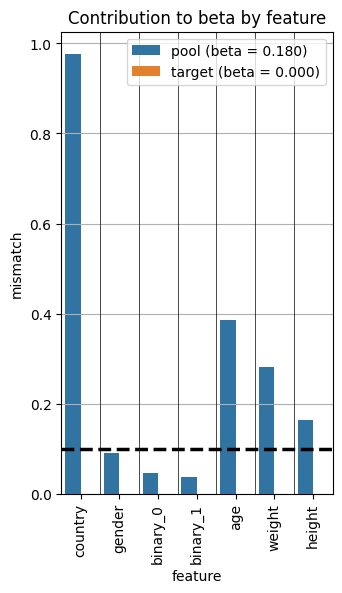

In [11]:
bc = BetaBalance(m)
fig = plot_per_feature_loss(m, bc)

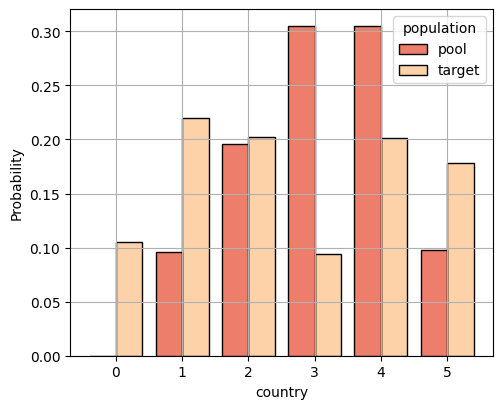

In [12]:
fig = plot_categoric_features(m, cumulative=False, palette='OrRd_r', include_binary=False)

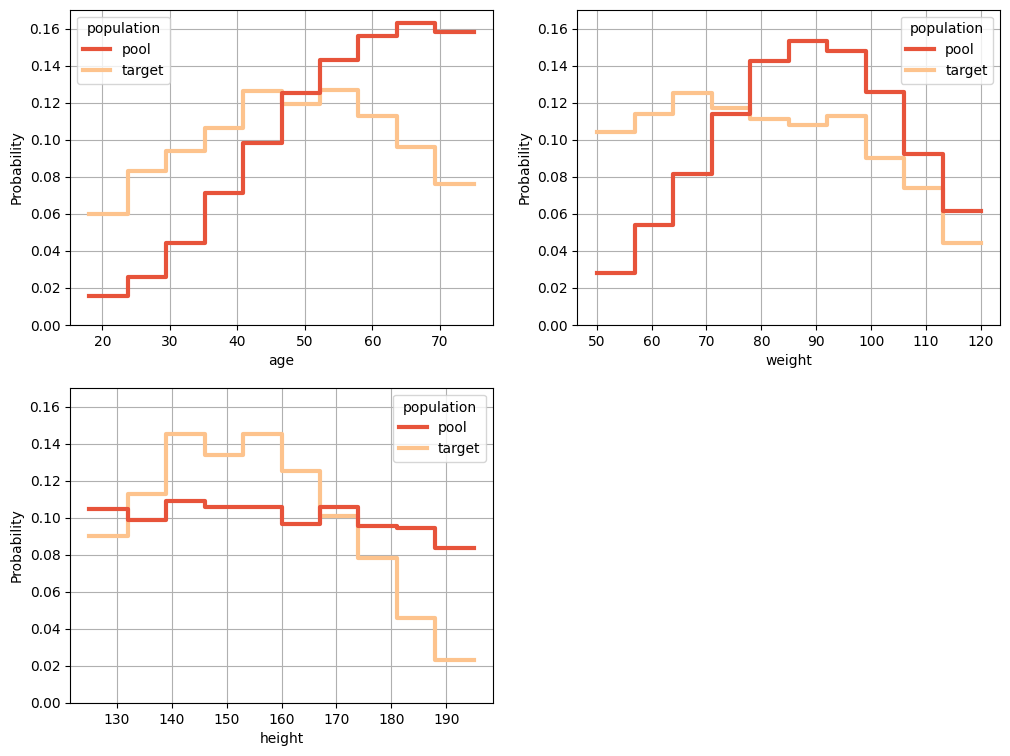

In [13]:
fig = plot_numeric_features(m, bins=10, cumulative=False, palette='OrRd_r')

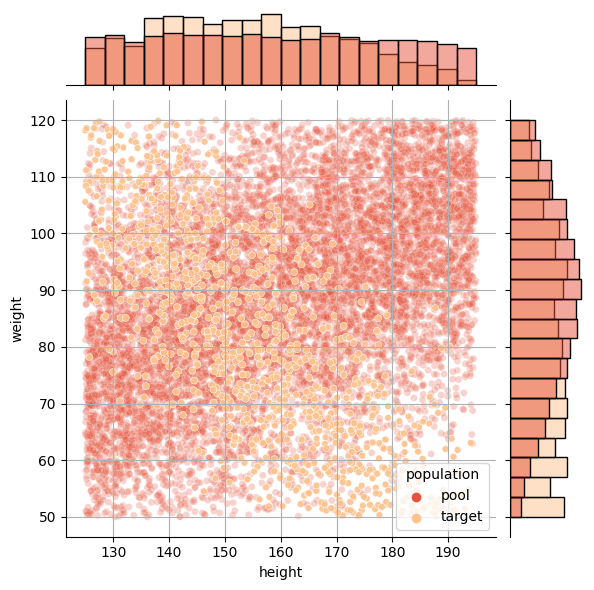

In [14]:
grids = plot_joint_numeric_distributions(m, include_only=['height', 'weight'], joint_kind='scatter', palette='OrRd_r')

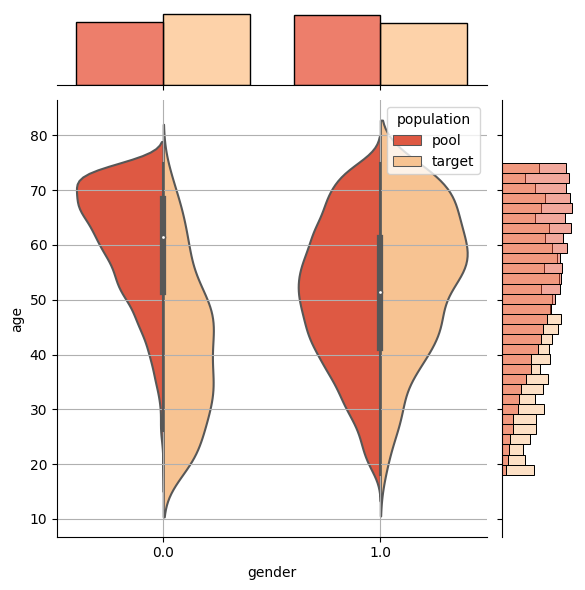

In [15]:
grids = plot_joint_numeric_categoric_distributions(
    m, 
    include_only_categoric=['gender'], 
    include_only_numeric=['age'], 
    palette='OrRd_r')